In [ ]:
import numpy as np
import math
import sklearn # Only for downloading MNIST Dataset and Accuracy Metrics
import sklearn.metrics
from keras.utils import to_categorical  # Only for categorical one hot encoding
import random

In [ ]:
antiCategorical = lambda x: [np.argmax(i) for i in x]
linear = lambda x : x

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
sigmoid = lambda x: 1/(1+math.e**-x)
# softmax = lambda x: math.e**x/(np.sum(math.e**x, axis=-1))
softmax = lambda x : tf.nn.softmax(x).numpy()

class Activation():
  def __init__(self):
    pass
  def __call__(self, x):
    pass
  def derivative(self, x):
    pass

class Sigmoid(Activation):
  def __call__(self, x):
    return sigmoid(x)
  def derivative(self, x):
    return sigmoid(x)*(1-sigmoid(x))

class Linear(Activation):
  def __call__(self, x):
    return x
  def derivative(self, x):
    return 1

class Relu(Activation):
  def __call__(self, x):
    return (x+(np.abs(x)))/2
  def derivative(self, x):
    return (np.sign(x)+1) / 2

class Tanh(Activation):
  def __call__(self, x):
    return np.tanh(x)
  def derivative(self, x):
    return np.nan_to_num(1-np.tanh(x)**2)

class LeakyRelu(Activation):
  def __call__(self, x):
    return tf.nn.leaky_relu(x , 0.01).numpy()
  def derivative(self, x):
    return (np.sign(x)+1) / 2

class SoftPlus(Activation):
  def __call__(self, x):
    return np.log(1 + np.exp(x))
  def derivative(self, x):
    return sigmoid(x)

class Softmax(Activation):
  def __call__(self, x):
    return softmax(x)
  def derivative(self, x):
    return 1

class Loss():
  def __call__(self, actual, pred):
    pass
  def derivative(self, actual, pred):
    pass

class MeanSquaredError(Loss):
  def __call__(self, actual, pred):
    return (0.5 * (pred - actual)) ** 2
  def derivative(self, actual, pred):
    return (pred - actual) 

class MeanAbsoluteError(Loss):
  def __call__(self, actual, pred):
    return (pred - actual)
  def derivative(self, actual, pred):
    return np.sign(self(actual, pred))

class SoftmaxCrossEntropy(Loss):
  def __call__(self, actual, pred):
    pred = softmax(pred)
    return np.nan_to_num(-actual * np.log(pred) - (1-actual) * np.log(1-pred))
  def derivative(self, actual, pred):
    pred = softmax(pred)
    return np.nan_to_num(pred - actual)

class CrossEntropy(Loss):
  def __call__(self, actual, pred):
    return np.nan_to_num(-actual * np.log(pred) - (1-actual) * np.log(1-pred))
  def derivative(self, actual, pred):
    return np.nan_to_num((-actual / (pred + 1e-8)) + ((1-actual) / ((1-pred) + 1e-8)))

class Layer:
  def __init__(self, last_layer):
    self.last_layer = last_layer
    return None
  def forwardProp(self):
    return None
  def updateParams(self, learning_rate):
    return None
  def backProp(self, errors):
    return errors
  def reverseProp(self, errors):
    return errors


global idd
idd = 0

class BatchNormalization:
  def __init__(self, last_layer, gamma=1, beta=0, eps=1e-5):
    global idd
    self.id = idd
    idd += 1
    self.gamma = gamma
    self.beta = beta
    self.eps = eps
    self.last_layer = last_layer
    self.size = last_layer.size

  def forwardProp(self):
    x = self.last_layer.forwardProp()
    N, D = x.shape
    sample_mean = x.mean(axis=0)
    sample_var = x.var(axis=0)
    self.std = np.sqrt(sample_var + self.eps)
    self.x_centered = x - sample_mean
    self.x_norm = self.x_centered / self.std
    out = self.gamma * self.x_norm + self.beta
    self.outputs = out
    return out

  def updateParams(self, learning_rate):
    self.gamma -= self.dgamma
    self.beta -= self.dbeta
    pass

  def backProp(self, errors):
    N = errors.shape[0]
    dgamma = (errors * self.x_norm).sum(axis=0)
    dbeta = errors.sum(axis=0)
    
    dx_norm = errors * self.gamma
    # dx_centered = dx_norm / self.std
    # dmean = -(dx_centered.sum(axis=0) + 2/N * self.x_centered.sum(axis=0))
    # dstd = (dx_norm * self.x_centered * -self.std**(-2)).sum(axis=0)
    # dvar = dstd / 2 / self.std
    # dx = dx_centered + (dmean + dvar * 2 * self.x_centered) / N


    dx = 1/N / self.std * (N * dx_norm - 
                      dx_norm.sum(axis=0) - 
                      self.x_norm * (dx_norm * self.x_norm).sum(axis=0))    

    self.dgamma = dgamma
    self.dbeta = dbeta
    return self.last_layer.backProp(dx)
    
  def resetAll(self):
    self.dgamma = 0
    self.dbeta = 0

class Dense(Layer):
  def __init__(self, size, last_layer, activation=Relu):
    global idd
    self.id = idd
    idd += 1
    #print(self.id)
    self.size = size
    self.activation = activation
    self.weights = np.random.normal(0, scale=(1/float(math.sqrt(last_layer.size))), size=(last_layer.size, size)).astype(np.float64)
    self.outputs = None
    self.errors = None
    self.sums = None
    self.last_layer = last_layer
    self.freeze = False

  def forwardProp(self):
    self.sums = np.dot(self.last_layer.forwardProp(), self.weights)
    self.outputs = self.activation(self.sums)
    return self.outputs

  def backProp(self, errors):
    self.errors = errors * self.activation.derivative(self.sums)
    backErrors = np.dot(self.errors, self.weights.T)
    return self.last_layer.backProp(backErrors)

  def reverseProp(self, errors):
    inv_weight = np.linalg.pinv(self.weights)
    backErrors = np.nan_to_num(np.dot(inverse_functions[self.activation](errors), inv_weight.T))
    return self.last_layer.reverseProp(backErrors)

  def updateParams(self, learning_rate):
    # Firstly update params of last layer
    if self.errors is None or self.freeze == True:
      return
    self.last_layer.updateParams(learning_rate)
    delta = np.dot(self.last_layer.outputs.T, self.errors) 
    # print(delta.shape)
    self.weights -= learning_rate*delta
    self.sums = None
    self.errors = None

  def resetAll(self):
    self.last_layer.resetAll()
    self.sums = None
    self.errors = None
    self.outputs = None
    return None

class Conv1D(Layer):
  def __init__(self, filters, kernel_size, last_layer, activation=Relu):
    global idd
    self.id = idd
    idd += 1
    #print(self.id)
    self.kernel_size = kernel_size
    self.filters = filters
    self.size = size
    self.activation = activation
    self.weights = np.random.normal(0, scale=(1/float(math.sqrt(last_layer.size))), size=(size, last_layer.size))
    self.outputs = None#np.zeros(size)
    self.errors = None#np.zeros(size)
    self.sums = None#np.zeros(size)
    self.last_layer = last_layer
  def forwardProp(self):
    self.outputs = self.activation(self.sums)
    return self.outputs
  def backProp(self, errors):
    backErrors = errors
    return self.last_layer.backProp(backErrors)
  def updateParams(self, learning_rate):
    return None
  def resetAll(self):
    self.last_layer.resetAll()
    self.sums = None
    self.errors = None
    self.outputs = None
    return None
  
class Input(Layer):
  def __init__(self, size, activation=Linear):
    global idd
    self.id = idd
    idd += 1
    self.size = size
    self.activation = activation
    self.outputs = np.zeros(size).astype(np.float64)
    self.sums = np.zeros(size).astype(np.float64)
    self.errors = None
  def forwardProp(self):
    #print("Input ", self.id)
    self.outputs = self.activation(self.sums)
    return self.outputs
  def backProp(self, errors):
    self.errors = errors * self.activation.derivative(self.sums)
    return self.errors
  def reverseProp(self, errors):
    return errors
  def updateParams(self, lr):
    return None
  def resetAll(self):
    self.sums = None
    self.outputs = None
    return None
    
class NeuralNet:
  def __init__(self,  inputs, outputs, learning_rate = 0.01, loss='crossentropy', gamma=1, delta=2):
    global idd
    idd = 0
    self.learning_rate = learning_rate
    self.Input = inputs
    self.Output = outputs
    self.loss = loss
    self.gamma = gamma
    self.delta = delta
  def forward(self, inputs):
    self.Input.sums = inputs
    return self.Output.forwardProp()
  def backward(self, errors):
    #self.Output.errors = errors
    return self.Output.backProp(errors) #* self.Output.activation.derivative(self.Output.Sum)
  def reverse(self, errors):
    #self.Output.errors = errors
    return self.Output.reverseProp(errors)
  def updateParams(self):
    self.Output.updateParams(self.learning_rate)
  
  def fit(self, X, Y, epoch=10, batch_size=10, verbose=True, validation_set = None, accuracy_metric=antiCategorical):
    X = X.reshape(tuple([-1, batch_size] + list(X.shape[1:])))
    Y = Y.reshape(tuple([-1, batch_size] + list(Y.shape[1:])))
    print(X.shape, Y.shape)
    iters = X.shape[0]
    for j in range(epoch):
      TotalLoss = 0
      for i in range(0, iters):
        self.resetAll()
        # print(X[i].shape)
        pred = self.forward(X[i].astype(np.float64))
        # print(pred)
        loss = self.loss.derivative(Y[i].astype(np.float64), pred.astype(np.float64))
        TotalLoss += sum(abs(k) for k in loss)
        self.backward(loss)
        self.updateParams()
      if verbose:
        print("Epoch",j, "Loss", TotalLoss/iters)
      self.learning_rate *= self.gamma
      self.gamma *= self.delta
      if validation_set is not None:
        tx, ty = validation_set
        pred = self.predict(tx)
        loss = self.loss.derivative(ty, pred)
        print("Validation Score:", sklearn.metrics.accuracy_score(accuracy_metric(ty), accuracy_metric(pred))*100, "\tLoss:", np.sum([sum(abs(k) for k in ll) for ll in loss])/len(ty))
    return None
  
  def test(self, tx, ty, accuracy_metric=antiCategorical):
      pred = self.predict(tx)
      loss = self.loss.derivative(ty, pred)
      print("Testing Score:", sklearn.metrics.accuracy_score(accuracy_metric(ty), accuracy_metric(pred))*100, "\tLoss:", np.sum([sum(abs(k) for k in ll) for ll in loss])/len(ty))


  def reversePredict(self, Y):
    iters = Y.shape[0]
    X = list()
    for i in range(iters):
      self.resetAll()
      pred = self.reverse(Y[i].astype(np.float64))
      #print(i, pred)
      X.append(pred)
    return np.array(X)

  def resetAll(self):
    self.Output.resetAll()
  
  def __call__(self, X):
    return self.predict(X)

  def predict(self, X):
    pred = self.forward(X.astype(np.float64))
    # self.resetAll()
    return pred
  def getLoss(self, pred, exp):
    return np.nan_to_num(loss_derivatives[self.loss][self.Output.activation](exp, pred))

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
cy_train = np.array(to_categorical(y_train))
cy_test = np.array(to_categorical(y_test))

cx_train, cx_test = np.array(x_train.reshape(-1, 784)/255.), np.array(x_test.reshape(-1, 784)/255.)
cx_train.shape

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)

In [ ]:
inputs = Input(784, LeakyRelu())
x = Dense(100, inputs, LeakyRelu())
x = BatchNormalization(x)
x = Dense(50, x, LeakyRelu())
x = BatchNormalization(x)
outputs = Dense(10, x, Sigmoid())

test = NeuralNet(inputs, outputs, learning_rate = 0.01, loss=MeanSquaredError(), delta=0.95, gamma=1)
test.fit(cx_train, cy_train, batch_size=10, epoch=10, validation_set=(cx_test, cy_test))

(6000, 10, 784) (6000, 10, 10)
Epoch 0 Loss [0.74676092 0.70794402 1.08777574 1.0598988  1.14294639 1.14708512
 0.88173004 0.90120414 1.15355366 1.20805714]
Validation Score: 67.02 	Loss: 0.8857429274697666
Epoch 1 Loss [0.64208616 0.6052423  0.95959072 0.98038288 1.07119448 1.06132734
 0.78075408 0.79759192 1.09425636 1.15174095]
Validation Score: 67.36 	Loss: 0.8649890802456124
Epoch 2 Loss [0.62909634 0.5907622  0.95231223 0.98513885 1.07073552 1.06479916
 0.7753565  0.79070116 1.09434628 1.1520661 ]
Validation Score: 67.57 	Loss: 0.8638068174282795
Epoch 3 Loss [0.62449113 0.58428625 0.95229097 0.98819208 1.07135848 1.06702534
 0.77408878 0.78949677 1.09752807 1.15459746]
Validation Score: 67.82000000000001 	Loss: 0.8639189542720973
Epoch 4 Loss [0.62243391 0.58065508 0.95340478 0.99200736 1.07367703 1.07187527
 0.77300446 0.78949573 1.10250122 1.15753719]
Validation Score: 68.28 	Loss: 0.8646451301905453
Epoch 5 Loss [0.62088261 0.57782743 0.95623166 0.99663181 1.07775876 1.078922

# GAN -->

In [ ]:
def generator():
  inputs = Input(256, LeakyRelu())
  x = Dense(512, inputs, LeakyRelu())
  # x = BatchNormalization(x)
  x = Dense(1024, x, LeakyRelu())
  # x = BatchNormalization(x)
  outputs = Dense(784, x, Sigmoid())

  model = NeuralNet(inputs, outputs, learning_rate = 0.005, loss=MeanSquaredError(), delta=0.98, gamma=1)
  return model

def descriminator():
  inputs = Input(784, LeakyRelu())
  x = Dense(512, inputs, LeakyRelu())
  # x = BatchNormalization(x)
  # x = Dense(256, x, LeakyRelu())
  # x = BatchNormalization(x)
  x = Dense(50, x, LeakyRelu())
  # x = BatchNormalization(x)
  desOut = Dense(1, x, Sigmoid())
  clsOut = Dense(10, x, Sigmoid())

  des = NeuralNet(inputs, desOut, learning_rate = 0.005, loss=MeanSquaredError(), delta=0.98, gamma=1)
  cls = NeuralNet(inputs, clsOut, learning_rate = 0.01, loss=SoftmaxCrossEntropy(), delta=0.98, gamma=1)
  return des, cls

In [ ]:
def trainGan(inputs, labels, cls, des, gen, epochs=10, batch_size=5, desSteps=1, genSteps=1, loss=MeanSquaredError(), clsLoss=SoftmaxCrossEntropy()):
  realData = np.array(inputs).reshape(tuple([-1, batch_size] + list(inputs.shape[1:])))
  clsData = np.array(inputs).reshape(tuple([-1, batch_size] + list(inputs.shape[1:])))
  labels = labels.reshape(tuple([-1, batch_size] + list(labels.shape[1:])))
  print(labels.shape)

  def trainCls(realData, labels, cls, index, steps):
    for i in range(index, steps+index):
      try:
        real = clsData[i]
        label = labels[i]
        # print(label.shape)
      except:
        return

      pred = cls(real)
      
      clsloss = clsLoss.derivative(label.astype(np.float64), pred.astype(np.float64))

      cls.backward(clsloss)
      cls.updateParams()
      cls.resetAll()

  def trainDes(realData, des, gen, index, steps):
    for i in range(index, steps+index):
      try:
        real = realData[i]
      except:
        return
      noise = np.random.normal(size=[batch_size, gen.Input.size])
      fake = gen(noise)
      X = np.concatenate((fake, real), axis=0)
      pred = des(X)
      fake_output = pred[:batch_size]
      real_output = pred[batch_size:]

      fake_desloss = loss.derivative(np.zeros_like(fake_output).astype(np.float64), fake_output.astype(np.float64))
      real_desloss = loss.derivative(np.ones_like(real_output).astype(np.float64), real_output.astype(np.float64))

      desLoss = np.concatenate((fake_desloss, real_desloss), axis=0)
      des.backward(desLoss)
      des.updateParams()
      des.resetAll()

  def trainGen(des, gen, steps):
    for i in range(steps):
      noise = np.random.normal(size=[batch_size, gen.Input.size])
      fake = gen(noise)
      fake_output = des(fake)

      desloss = loss.derivative(np.ones_like(fake_output).astype(np.float64), fake_output.astype(np.float64))

      cls_output = cls(fake)
      similarityLoss = (10 - len(np.unique(antiCategorical(cls_output)))) / 5
      desloss += similarityLoss

      grad = des.backward(desloss)
      gen.backward(grad)
      gen.updateParams()
      gen.resetAll()
      des.resetAll()
      cls.resetAll()

  print(realData.shape)
  for epoch in range(epochs):
    np.random.shuffle(realData)
    for iter in range(len(realData)):
      trainCls(realData, labels, cls, iter, desSteps)
      trainDes(realData, des, gen, iter, desSteps)
      trainGen(des, gen, genSteps)
    
    noise = np.random.normal(size=[batch_size, gen.Input.size])
    real = realData[0]
    fake = gen(noise)
    cls_output = cls(fake)
    similarityLoss = (10 - len(np.unique(antiCategorical(cls_output)))) / 5
    X = np.concatenate((fake, real), axis=0)
    pred = des(X)
    fake_output = pred[:batch_size]
    real_output = pred[batch_size:]
    des.resetAll()
    gen.resetAll()
    print("Epoch ", epoch, "SimilarityLoss", similarityLoss, "Fake=>", fake_output, "Real=>", real_output)
    cls.test(cx_test, cy_test)
    for i in range(len(fake)):
      plt.imshow(fake[i].reshape((28,28)))
      plt.show()
    # print("==>", np.mean(desLoss), np.mean(genLoss))

In [ ]:
gen = generator()
des, cls = descriminator()

In [ ]:
cls.fit(cx_train, cy_train, batch_size=10, epoch=5, validation_set=(cx_test, cy_test))

(6000, 10, 784) (6000, 10, 10)
Epoch 0 Loss [1.53575838 1.62915209 1.56915572 1.60164692 1.56314882 1.529399
 1.54484685 1.60806567 1.58401246 1.61429446]
Validation Score: 93.47999999999999 	Loss: 1.558807240829851
Epoch 1 Loss [1.53069911 1.62392677 1.54833966 1.57929373 1.53799375 1.49116592
 1.53492082 1.58230086 1.54433428 1.56265217]
Validation Score: 95.44 	Loss: 1.551189778085763
Epoch 2 Loss [1.52986818 1.62381031 1.54387999 1.57031288 1.53268053 1.48414933
 1.53305581 1.57828028 1.53689341 1.5539813 ]
Validation Score: 96.56 	Loss: 1.5474626195240047
Epoch 3 Loss [1.52930138 1.62369804 1.54116286 1.56641478 1.52908959 1.48045581
 1.53187052 1.575688   1.53260683 1.54845206]
Validation Score: 96.98 	Loss: 1.5461580358037805
Epoch 4 Loss [1.52902712 1.62372345 1.53990327 1.56313662 1.52679588 1.47834328
 1.53123006 1.57409984 1.5300715  1.54448514]
Validation Score: 97.18 	Loss: 1.5452720859718099


(6000, 10, 10)
(6000, 10, 784)
Epoch  0 SimilarityLoss 1.6 Fake=> [[0.50034762]
 [0.49996202]
 [0.50013971]
 [0.50018575]
 [0.50011722]
 [0.50025551]
 [0.50027682]
 [0.50069347]
 [0.49998625]
 [0.50015222]] Real=> [[1.        ]
 [1.        ]
 [0.99999998]
 [1.        ]
 [1.        ]
 [0.9999996 ]
 [1.        ]
 [1.        ]
 [0.99999635]
 [1.        ]]
Testing Score: 97.11 	Loss: 1.5455173881344029


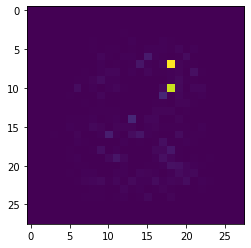

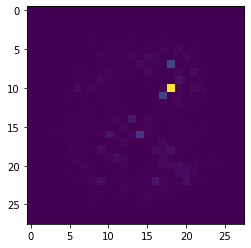

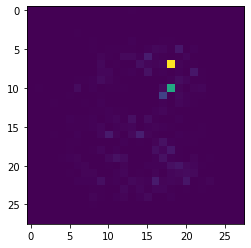

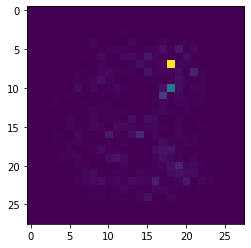

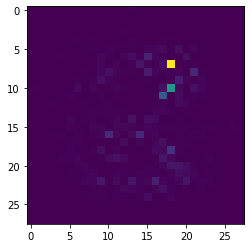

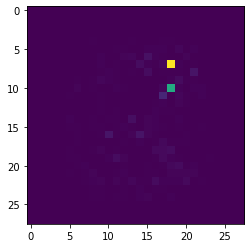

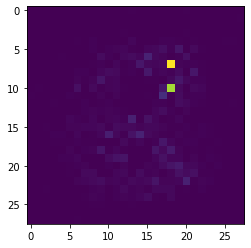

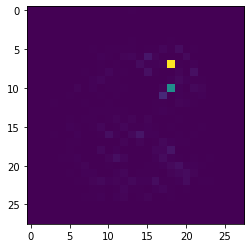

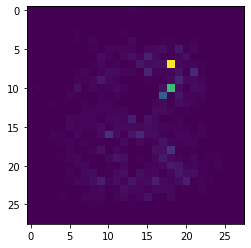

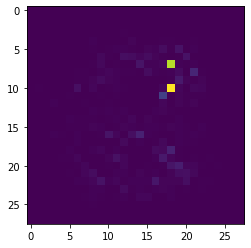

Epoch  1 SimilarityLoss 1.8 Fake=> [[0.49995038]
 [0.49989116]
 [0.50000922]
 [0.50004145]
 [0.50000667]
 [0.49996465]
 [0.49995446]
 [0.50003307]
 [0.49999067]
 [0.50000948]] Real=> [[0.99999995]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]]
Testing Score: 97.46000000000001 	Loss: 1.5445501778576007


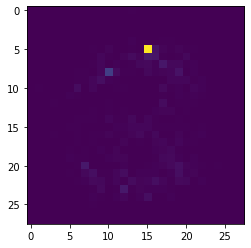

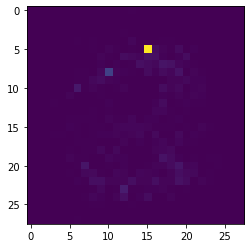

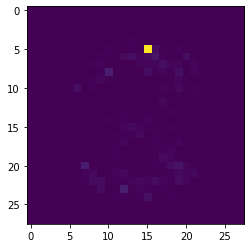

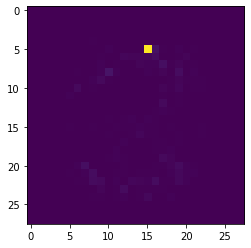

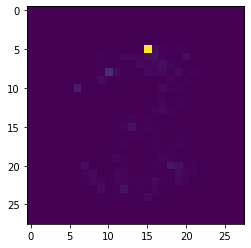

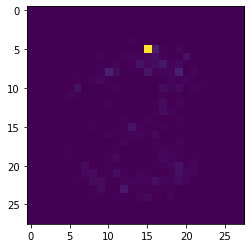

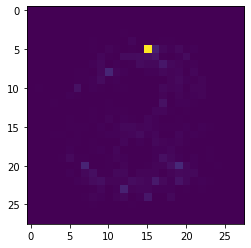

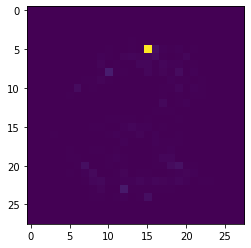

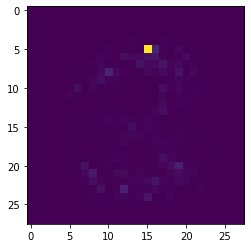

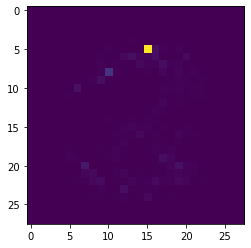

Epoch  2 SimilarityLoss 1.8 Fake=> [[0.49999712]
 [0.49995099]
 [0.4999998 ]
 [0.49995937]
 [0.49996312]
 [0.50000332]
 [0.49999265]
 [0.49981506]
 [0.49999468]
 [0.49999751]] Real=> [[1.        ]
 [1.        ]
 [0.99999843]
 [1.        ]
 [0.99997018]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]]
Testing Score: 97.59 	Loss: 1.543998122369391


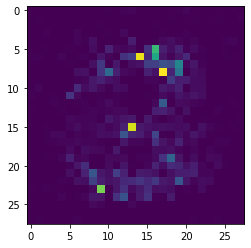

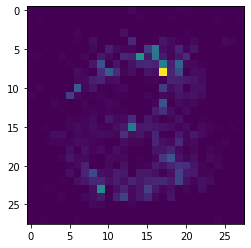

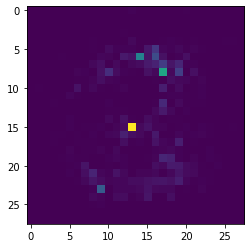

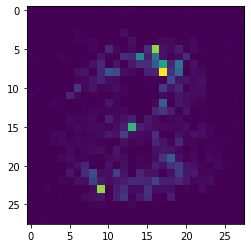

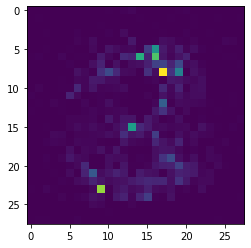

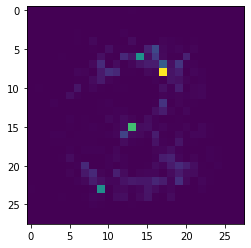

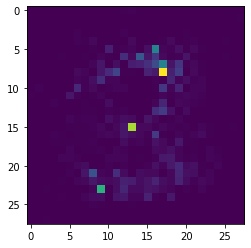

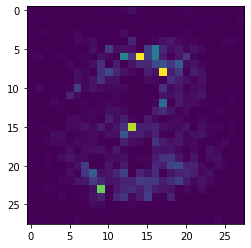

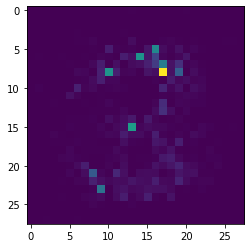

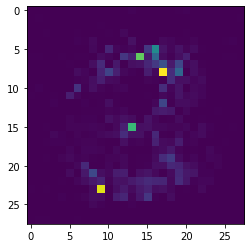

Epoch  3 SimilarityLoss 1.8 Fake=> [[0.49987499]
 [0.4999928 ]
 [0.49998595]
 [0.49992848]
 [0.49912927]
 [0.49990554]
 [0.49999505]
 [0.49998686]
 [0.49993688]
 [0.49982353]] Real=> [[0.99999972]
 [1.        ]
 [0.99999999]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]]
Testing Score: 97.84 	Loss: 1.5436451282942718


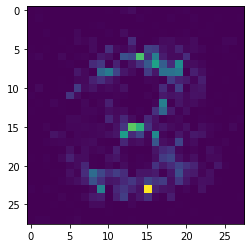

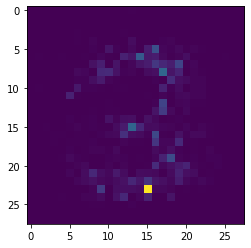

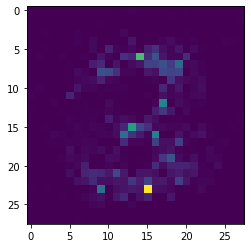

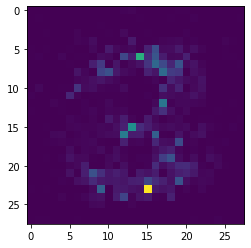

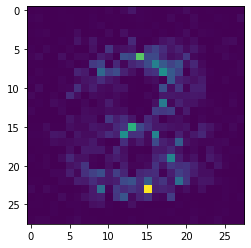

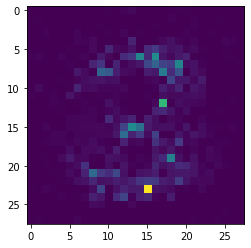

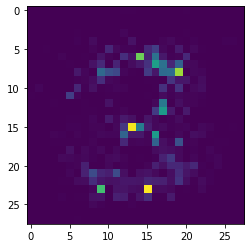

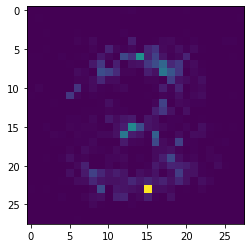

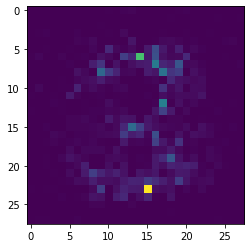

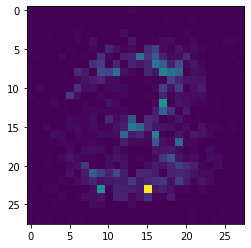

In [ ]:
trainGan(cx_train, cy_train, cls=cls, des=des, gen=gen, epochs=100, batch_size=10, desSteps=2, genSteps=1, loss=CrossEntropy())

In [ ]:
def trainGan(realData, epochs=10, batch_size=5, loss=MeanSquaredError()):
  realData = realData.reshape(tuple([-1, batch_size] + list(realData.shape[1:])))
  print(realData.shape)
  for epoch in range(epochs):
    np.random.shuffle(realData)
    for iter in range(len(realData)):
      noise = np.random.normal(size=[batch_size, 100])
      fake = gen(noise)
      real = realData[iter]
      X = np.concatenate((fake, real), axis=0)

      pred = des(X)

      fake_output = pred[:batch_size]
      real_output = pred[batch_size:]
      
      fake_desloss = loss.derivative(np.zeros_like(fake_output).astype(np.float64), fake_output.astype(np.float64))
      real_desloss = loss.derivative(np.ones_like(real_output).astype(np.float64), real_output.astype(np.float64))
      
      # print("=>", fake_desloss, real_desloss)

      genLoss = loss.derivative(np.ones_like(fake_output).astype(np.float64), fake_output.astype(np.float64))

      genLoss = des.backward(np.concatenate((genLoss, genLoss), axis=0))[:batch_size]
      gen.backward(genLoss)
      gen.updateParams()

      desLoss = np.concatenate((fake_desloss, real_desloss), axis=0)
      des.backward(desLoss)
      des.updateParams()

      des.resetAll()
      gen.resetAll()
      
    print("Epoch ", epoch, "Fake=>", fake_output, "Real=>", real_output)
    for i in range(len(fake)):
      plt.imshow(fake[i].reshape((28,28)))
      plt.show()
    # print("==>", np.mean(desLoss), np.mean(genLoss))

In [ ]:
gen = generator()
des = descriminator()
trainGan(cx_train, epochs=100, batch_size=20)